On souhaite **classer des images de cellules sanguines** en utilisant un CNN. Les images sont groupées en 11 classes :

- **BA** : BAsophiles
- **BNE** : NEutrophiles de Bande
- **EO** : EOsinophiles
- **ERB** : ERythroBlastes
- **LY** : LYmphocytes
- **MMY** : MétaMYélocytes
- **MO** : MOnocytes
- **MY** : MYélocytes
- **PLT** : PLaqueTtes
- **PMY** : Promyélocytes
- **SNE** : NEutrophiles Segmentés

L'approche choisie est le **Transfer Learning** : on utilise le modèle **Xception** et les poids optimisés pour ImageNet. Les données utilisées sont celles du dataset "Barcelone".

# Modules, connexion au drive, vérification du GPU

In [ ]:
## Gives access to the Drive
from google.colab import drive
drive.mount('/content/drive')

## Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

import sys, os
from pathlib import Path
import shutil
import glob
import itertools

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping

from tensorflow.keras.utils import Sequence
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append('/content/drive/MyDrive/Leukopy')
import leukopy_lib as leuko
from importlib import reload

reload(leuko)

## GPU status verification
tf.test.gpu_device_name()

## GPU type verification
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
Tue Oct 26 08:19:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    345MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

# Import des données

In [ ]:
## Need to copy all the files on the local computer
!cp -r "/content/drive/MyDrive/Leukopy/data/main_dataset.zip" .
!unzip main_dataset.zip

## Create the original dataframes 
path = Path('/content/main_dataset/')

df_train = leuko.generate_images_df(path/'training_set')
df_test = leuko.generate_images_df(path/'testing_set')
df_valid = leuko.generate_images_df(path/'validation_set')

# Preprocessing des données

On élimine le label "BL" du dataset : trop peu d'images, trop différentes du reste de Barcelone.

In [ ]:
df_train = df_train[df_train["label"] != "BL"]
df_test = df_test[df_test["label"] != "BL"]
df_valid = df_valid[df_valid["label"] != "BL"]

In [ ]:
n_classes = df_train["label"].nunique()

On découpe les données en une série de batchs de 32 images. Les images sont redimensionnées (360 * 360 pixels) et on programme une augmentation de données (rotation, symétries axiales).

In [ ]:
batch_size = 32
img_height  = 360
img_width = 360

train_generator = ImageDataGenerator(rotation_range = 90,
                                     horizontal_flip = True, 
                                     vertical_flip = True)
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (img_height, img_width), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   preprocessing_function = preprocess_input)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (img_height, img_width), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True,
                                                     preprocessing_function = preprocess_input)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (img_height, img_width),
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = False, 
                                                 preprocessing_function = preprocess_input)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

Found 12677 validated image filenames belonging to 11 classes.
Found 1730 validated image filenames belonging to 11 classes.
Found 2544 validated image filenames belonging to 11 classes.
Train : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Valid : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Test  : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


# Modèle

On crée une fonction calculant des poids, permettant de pénaliser l'erreur commise sur les classes les moins représentées du dataset. On espère ainsi compenser partiellement le déséquilibre du dataset.

In [ ]:
def compute_weights(training_set):
  counter = Counter(training_set.classes)                       
  class_weights = {class_id : (1/num_images)*float(sum(counter.values()))/2 for class_id, num_images in counter.items()}
  return class_weights

On construit ensuite le modèle : d'abord le bloc Xception, pré-entraîné sur ImageNet, puis une succession de couches Dense, ReLU + Dropout pour classer les images. Enfin, un ultime couche Dense avec Softmax comme activation, pour obtenir des probabilités d'appartenance aux classes.

Les paramètres d'Xception sont gelés : on fait du transfer learning.

On compile le modèle en utilisant Adam comme optimiseur, avec un taux d'apprentissage initialement égal à 0.0001. Sa valeur sera adaptée au cours de l'entraînement.

In [ ]:
# Model (Functional API)
inputs = layers.Input(shape = (img_height,img_width,3))
base_model = Xception(include_top = False,
                      weights = "imagenet",
                      input_tensor = inputs,
                      input_shape = (img_height,img_width,3),
                      pooling = 'avg')
base_model.training = False 
base_output = base_model.output
x = layers.Dense(units = 2048, activation = 'relu', name = 'dense_1')(base_output)
x = layers.Dropout(rate = 0.2, name = 'dropout_1')(x)
x = layers.Dense(units = 1024, activation = 'relu', name = 'dense_2')(x)
x = layers.Dropout(rate = 0.2, name = 'dropout_2')(x)
x = layers.Dense(units = 512, activation = 'relu', name = 'dense_3')(x)
x = layers.Dropout(rate = 0.2, name = 'dropout_3')(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax', name = 'final_softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Freeze EfficientNet
base_model.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

83689472/83683744 [==============================] - 1s 0us/step


On affiche la liste des couches du modèle :

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 360, 360, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 179, 179, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 179, 179, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 179, 179, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

# Entraînement (ne pas ré-exécuter)

On entraîne le modèle pour une durée maximale de 100 epochs. Ce sont les callbacks, définis ci-dessous et utilisant la fonction de coût calculée pour le jeu de validation, qui vont gérer :
- la valeur du taux d'apprentissage,
- le nombre d'epochs

In [ ]:
# Callbacks
TON = TerminateOnNaN()

control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-6)
  
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]
                    
## Compute weights :
class_weights = compute_weights(training_set)

## Training :
epochs = 100
training_history = model.fit(x = training_set, 
                             epochs = epochs,
                             callbacks = callbacks_list, 
                             validation_data = validation_set, 
                             class_weight = class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/40
397/397 [==============================] - 370s 887ms/step - loss: 36.5606 - accuracy: 0.2003 - val_loss: 1.9626 - val_accuracy: 0.2942
Epoch 2/40
397/397 [==============================] - 362s 911ms/step - loss: 12.3421 - accuracy: 0.2614 - val_loss: 1.8401 - val_accuracy: 0.3081
Epoch 3/40
397/397 [==============================] - 362s 913ms/step - loss: 11.0993 - accuracy: 0.2967 - val_loss: 1.7797 - val_accuracy: 0.3208
Epoch 4/40
397/397 [==============================] - 358s 901ms/step - loss: 10.4308 - accuracy: 0.3258 - val_loss: 1.6719 - val_accuracy: 0.3902
Epoch 5/40
397/397 [==============================] - 359s 905ms/step - loss: 10.0928 - accuracy: 0.3443 - val_loss: 1.7195 - val_accuracy: 0.3688
Epoch 6/40
397/397 [==============================] - 354s 893ms/step - loss: 9.7515 - accuracy: 0.3651 - val_loss: 1.6083 - va

In [ ]:
## Sauvegarde :
model.save("/content/drive/MyDrive/Leukopy/Xception_TL_11/model_fullsave")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/Xception_TL_11/model_fullsave/assets


On obtient une performance globale médiocre, malgré la réduction progressive du learning rate. Cependant, il n'y a pas de surapprentissage.

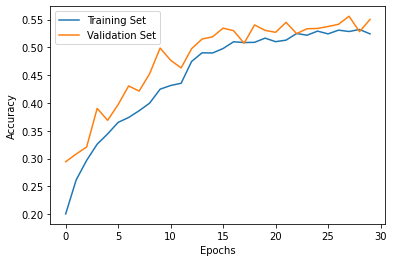

In [ ]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(early_stopping.stopped_epoch), training_accuracy[0:early_stopping.stopped_epoch], label = 'Training Set')
plt.plot(np.arange(early_stopping.stopped_epoch), validation_accuracy[0:early_stopping.stopped_epoch], label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Évaluation

Import des poids du modèle :

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Leukopy/Xception_TL_11/model_fullsave")

## Fonctions

In [ ]:
def print_classification_report(testing_set, labels, title):
  """
  Rapport de classification + Matrice de confusion
  """
  # Prédiction : utilise le jeu de test (testing_set)
  predictions = model.predict(testing_set)
  y_pred = tf.argmax(predictions, axis = 1)

  # Calcul et affichage de la matrice de confusion
  cnf_matrix = confusion_matrix(testing_set.classes, y_pred, normalize = 'true')
  classes = range(len(labels))
  
  plt.figure(figsize = (12,12))
  plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
  plt.title("Matrice de confusion - "+title)
  plt.colorbar()

  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), 
                                range(cnf_matrix.shape[1])):
    plt.text(j, i, np.around(cnf_matrix[i, j], decimals = 3),
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

  # Rapport de classification 
  report = classification_report(testing_set.classes, y_pred, target_names = labels, output_dict = True)

  df_report = pd.DataFrame(index = list(report.keys())[:-3], columns = list(report["BA"].keys()))
  for key in list(report.keys())[:-3]:
    for column in list(report["BA"].keys()):
      df_report.loc[key, column] = report[key][column]
  
  print("Classification Report - "+title)
  return y_pred, display(df_report)

Fonctions pour Grad-CAM :

In [ ]:
def get_img_array(img_path, size = (img_height, img_width)):
  """
  Importe une image et applique le preprocessing nécessaire à l'utilisation de Xception : batch + preprocess_input
  """
  img_array = tf.keras.preprocessing.image.load_img(img_path, target_size = size)
  img_array = tf.keras.preprocessing.image.img_to_array(img_array)
  img_array = np.expand_dims(img_array, axis = 0)
  img_array = preprocess_input(img_array)

  return img_array


def make_heatmap(img_array, model, last_conv_layer, class_index):
  """
  Calcule la CAM (Class Activation Map) correspondant au label d'indice "class_index" pour l'image "img_array"
  model : un modèle déjà entraîné, dont on désactive la fonction d'activation en sortie (fait dans grandcam())
  last_conv_layer : dernière couche de convolution du modèle. Trouvée automatiquement par la fonction gradcam()
  class_index : renseigné dans l'appel de gradcam() ou trouvé automatiquement par gradcam()
  """
  grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    class_channel = preds[:, class_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

  heatmap_tmp = last_conv_layer_output[0].numpy()

  # Multiplie chaque carte d'activation par le gradient, puis moyenne
  for i in range(last_conv_layer_output.shape[3]):
    heatmap_tmp[:,:,i] *= pooled_grads[i]
  heatmap = np.mean(heatmap_tmp, axis=-1)

  return heatmap


def gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.5, plot = True):

  # Désactive softmax sur la dernière couche :
  model.layers[-1].activation = None

  # Détecte la dernière couche de convolution du modèle :
  for layer in reversed(model.layers):
    if 'conv' in layer.name:
      last_conv_layer = model.get_layer(layer.name)
      break

  # Chargement + preprocessing de l'image (conversion, batch, vgg19 special preprocessing):
  img_array = get_img_array(img_path, size = (img_height, img_width))

  # Choix de la classe à représenter (si class_index non renseigné) :
  if class_index == None :
    # Désactiver Sotfmax sur la couche de sortie :
    #model.layers[-1].activation = None                        # Modif
    # Trouve la classe la plus probable :
    predict = model.predict(img_array)
    class_index = np.argmax(predict[0])

  # Calcul de la CAM : resize pour superposition avec l'image finale
  heatmap = make_heatmap(img_array, model, last_conv_layer, class_index)
  big_heatmap = heatmap

  # Réactive softmax :
  model.layers[-1].activation = tf.keras.activations.softmax

  ## Traitement de la Heatmap
  # Applique ReLu (élimine les valeurs négatives de la heatmap)
  big_heatmap = np.maximum(0, big_heatmap)
  # Normalisation
  big_heatmap = big_heatmap/big_heatmap.max()

  ## Superposition de l'image et de la heatmap 
  # 1/ Import de l'image d'origine
  img = tf.keras.preprocessing.image.load_img(img_path)
  img = tf.keras.preprocessing.image.img_to_array(img)

  # 2/ Rescale heatmap: 0-255
  big_heatmap = np.uint8(255*big_heatmap)
  # 3/ Jet colormap
  jet = cm.get_cmap("jet")
  # 4/ Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[big_heatmap]
  # 5/ Create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
  # 6/ Superimpose the heatmap on original image
  superimposed_img = jet_heatmap*alpha + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  if plot == True:
    # 7/ Affichage des résultats
    fig = plt.figure(figsize = (8,8))
    fig.add_subplot(1,2,1)
    plt.imshow(big_heatmap)

    fig.add_subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Chosen class : "+str(list(label_map.keys())[class_index]))

  return big_heatmap, superimposed_img

## Performances : métriques

In [ ]:
## Évaluation sur les données de test :
model.evaluate(testing_set)

80/80 [==============================] - 33s 207ms/step - loss: 1.2129 - accuracy: 0.5790


[1.2128692865371704, 0.5790094137191772]

On arrive à un maigre ~58% en accuracy globale, ce qui n'est pas bon. L'accuracy mesurée sur le jeu de test est cependant supérieure à celle mesurée sur le jeu d'entraînement : il n'y a **pas d'overfitting**, mais des **doutes quant à la capacité du modèle à modéliser correctement** chaque classe de cellules. Nous sommes **peut-être en situation d'underfitting**. 

**Entrons dans le détail** en calculant la matrice de confusion et les métriques **pour chaque classe** (F1-Score, Rappel, Précision) :

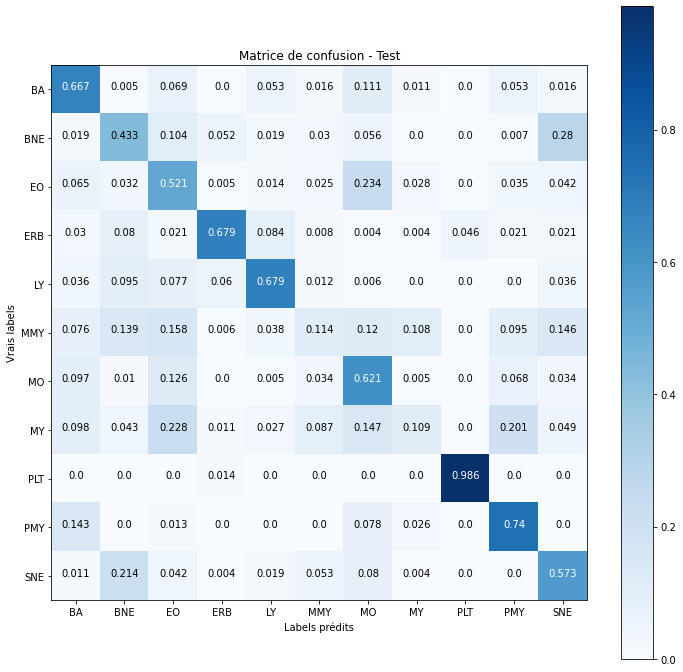

Classification Report - Test


,precision,recall,f1-score,support
BA,0.533898,0.666667,0.592941,189
BNE,0.456693,0.432836,0.444444,268
EO,0.578406,0.520833,0.548112,432
ERB,0.821429,0.679325,0.743649,237
LY,0.662791,0.678571,0.670588,168
MMY,0.222222,0.113924,0.150628,158
MO,0.376471,0.621359,0.468864,206
MY,0.357143,0.108696,0.166667,184
PLT,0.97019,0.986226,0.978142,363
PMY,0.367742,0.74026,0.491379,77


In [ ]:
y_pred, df_report = print_classification_report(testing_set, label_map, title = "Test")

L'allure de la matrice de confusion confirme que **le modèle a du mal à trouver une bonne représentation de chaque classe** : une classe n'est pas confondue avec seulement une voire deux autres, mais avec cinq autres classes en moyenne.

Les plaquettes sortent du lot, puisque leur F1-Score atteint pratiquement 98%, mais ces cellules sont de petite taille et sont celles qui ressortent le plus dans le dataset.

## Enquête : Grad-CAM

Nous allons utiliser Grad-CAM pour déterminer ce que le modèle parvient à "retenir" des images du jeu d'entraînement. On espère trouver une explication à ce piètre résultat.


Dans un premier temps, on stocke les résultats de l'évaluation dans un dataframe : df_results. La variable "well_classified" permet de savoir si l'image a été bien classée ou non.

In [ ]:
df_results = pd.DataFrame(data = {"label":testing_set.classes,
                                  "label_pred":y_pred, 
                                  "img_path":df_test["img_path"]})

df_results["well_classified"] = np.where(df_results["label"] == df_results["label_pred"], True, False)

Utilisons Grad-CAM sur les images bien classées : on choisit au hasard une image bien classée de chaque classe.

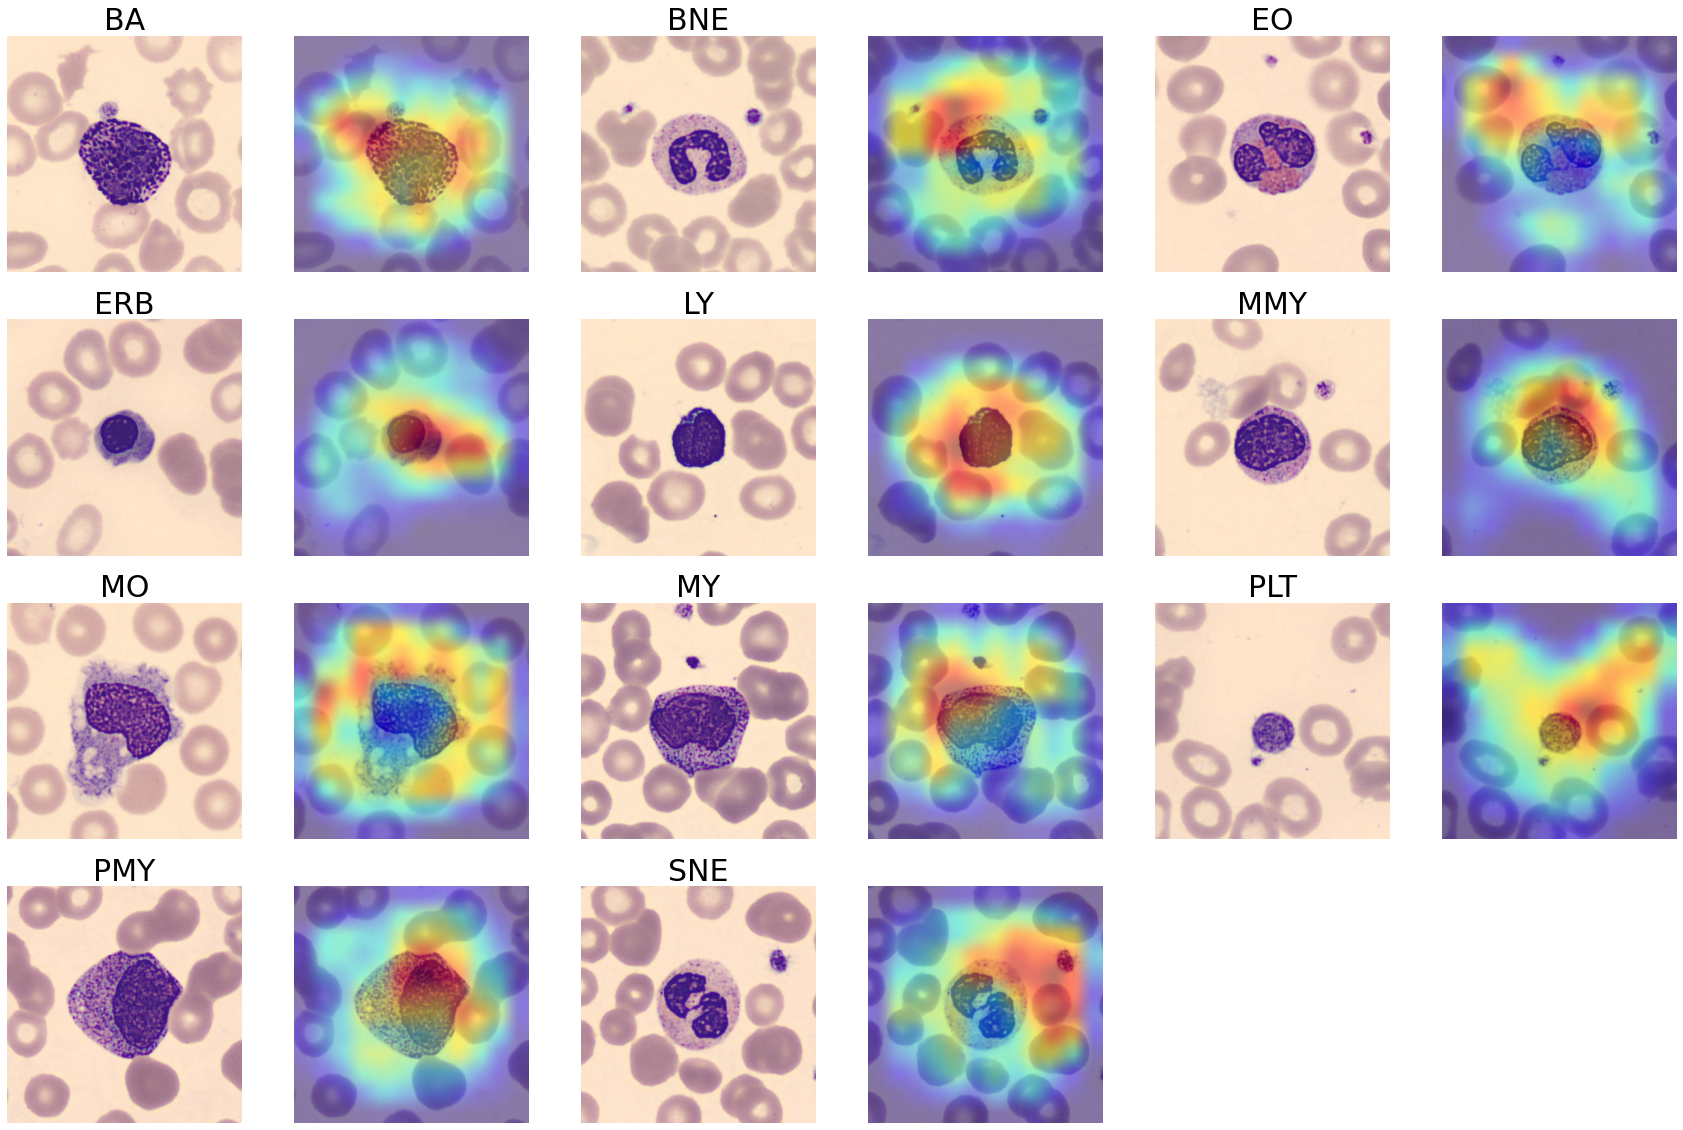

In [ ]:
fig = plt.figure(figsize = (30, 20))
i = 0

for cell_class in range(n_classes):
  df_temp = df_results[(df_results["label"] == cell_class) & (df_results["well_classified"] == True)]
  id = np.random.choice(df_temp.index, size = 1, replace = False)
  img_path = df_temp.loc[id[0],"img_path"]
 
  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, 
                                          class_index = None, alpha = 0.8, plot = False)

  fig.add_subplot(4,6,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(list(label_map.keys())[cell_class], fontsize = 30)
  plt.grid(None)
  plt.axis('off')

  fig.add_subplot(4,6,i+2)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  i += 2

Bien souvent, on remarque **le modèle concentre son attention sur la zone située au voisinage immédiat de la cellule** et non sur la cellule elle-même. Même dans les rares cas où la cellule figure dans la zone d'intérêt, celle-ci englobe une portion non négligeable du reste de l'image. Cela confirme ce que nous supposions : **le modèle ne parivent pas à saisir l'information utile** dans ce dataset.